In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
plt.rc("font", family="Malgun Gothic") # wind 기본 한글폰트

# 전처리

## 주유소 가격

In [2]:
# 다운로드한 파일 불러오기
station = pd.read_csv('data/주유소_평균판매가격_제품별.csv', encoding='cp949')

# row데이터 : 2010년 1월 2일 ~ 2021년 9월 1일 (날짜 조정) // 주유소 금액은 하루전 가격으로 발표 
station['날짜']=pd.to_datetime(station['구분'].str.replace('년','-').str.replace('월','-').str.replace('일',''))
station['날짜'] = station['날짜'] - datetime.timedelta(days=1)
station.drop(['구분'], axis=1, inplace=True)

# 보통휘발유의 30일 이전대비 증감비율 계산 // 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(station)) :
    try :
        temp = ((station.loc[idx, '보통휘발유'] - station.loc[idx-30, '보통휘발유']) / station.loc[idx-30, '보통휘발유']).round(6)
        station.loc[idx, '보휘-30'] = temp
    except KeyError as e :
        station.loc[idx, '보휘-30'] = np.nan
        
station = station[['날짜', '고급휘발유', '보통휘발유', '자동차용경유', '실내등유', '보휘-30']]
station_df = station.copy()    # 새로운 DF에 복사

# 파일 저장
station_df.to_csv('data/station_df.csv', index=None)

## 국제 원유 가격

In [3]:
# 다운로드한 파일 불러오기
crude = pd.read_csv('data/국제_원유가격20100102_20210901.csv', encoding='cp949')

# row데이터 : 2010년 1월 2일 ~ 2021년 9월 1일 (날짜 조정) // 원유 금액은 시차로 인하여 전날 요금을 조사
crude['기간'] = '20'+crude['기간']
crude['날짜']=pd.to_datetime(crude['기간'].str.replace('년','-').str.replace('월','-').str.replace('일',''))
crude['날짜'] = crude['날짜'] - datetime.timedelta(days=1)
crude.drop(['기간'], axis=1, inplace=True)

# '-'로 되어있는 결측치 NaN으로 변경 + 숫자로 타입변환
crude.replace('-', np.nan, inplace=True)
crude['Dubai'] = pd.to_numeric(crude['Dubai'])
crude['Brent'] = pd.to_numeric(crude['Brent'])
crude['WTI'] = pd.to_numeric(crude['WTI'])

# 세종류 원유의 평균값 추출
crude['평균'] = crude[['Dubai', 'Brent', 'WTI']].mean(axis=1).round(2)

# 평균의 30일 이전대비 증감비율 계산 : 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(crude)) :
    try :
        temp = ((crude.loc[idx, '평균'] - crude.loc[idx-30, '평균']) / crude.loc[idx-30, '평균']).round(6)
        crude.loc[idx, '평균-30'] = temp
    except KeyError as e :
        crude.loc[idx, '평균-30'] = np.nan

crude = crude[['날짜', 'Dubai', 'Brent', 'WTI', '평균', '평균-30']]
crude_df = crude.copy()    # 새로운 DF에 복사

# 파일 저장
crude_df.to_csv('data/crude_df.csv', index=None)

## 정유사 공급가격

In [4]:
# 다운로드한 파일 불러오기
refinery = pd.read_csv('data/정유사_주간공급가격_제품별.csv', encoding='cp949')

# 정유사 금액은 전주의 일요일(-10)~토요일(-4) 기준 -> 전주 수요일 기준으로 임의날짜 조정
refinery['날짜'] = '2009-12-30'
refinery['날짜'] = pd.to_datetime(refinery['날짜'])
for idx in range(1, len(refinery)) :
    refinery['날짜'][idx] = refinery['날짜'][0] + datetime.timedelta(days=(7 * idx))
refinery.drop(0, inplace=True)
refinery.index = range(refinery.shape[0])

# 보통휘발유의 4주전 대비 증감비율 계산 : 30일 이전 데이터 없는 경우 NaN 처리
for idx in range(len(refinery)) :
    try :
        temp = ((refinery.loc[idx, '보통휘발유'] - refinery.loc[idx-4, '보통휘발유']) / refinery.loc[idx-4, '보통휘발유']).round(6)
        refinery.loc[idx, '보휘-4w'] = temp
    except KeyError as e :
        refinery.loc[idx, '보휘-4w'] = np.nan

refinery = refinery[['날짜', '고급휘발유', '보통휘발유', '자동차용경유', '실내등유', '보휘-4w']]
refinery_df = refinery.copy()    # 새로운 DF에 복사

# 파일 저장
refinery_df.to_csv('data/refinery_df.csv', index=None)

## 주유소별 역대 가격

### 반복 다운로드를 위한 웹크롤링

In [ ]:
# 파일 다운로드 사이트
# https://www.opinet.co.kr/user/opdown/opDownload.do
# 이 페이지에 1920*1080 해상도 모니터로 접속했을 경우의 x, y 좌표 기준
# 사이트의 설정상 월단위 다운로드 가능

import pyautogui
import time

pyautogui.click(x=650, y=809, clicks=2)
date_list = pd.read_csv('data/date.csv')
date_list = np.array(date_list[3:140])

for date in date_list:
    # 시작날짜 입력창 더블클릭
    start = str(date[0])
    end = str(date[1])
    pyautogui.click(x=1045, y=547, clicks=1)
    pyautogui.click(x=655, y=809, clicks=2)
    pyautogui.typewrite('')
    pyautogui.typewrite(start)
    time.sleep(1)
    # 종료날짜 입력창 더블클릭
    pyautogui.click(x=775, y=807, clicks=2)
    time.sleep(1)
    pyautogui.typewrite('')
    pyautogui.typewrite(end)
    # CSV저장 버튼 클릭
    pyautogui.click(x=1477, y=859, clicks=1)
    time.sleep(3)
     # 계속진행하시겠습니까? 확인버튼 클릭
    pyautogui.click(x=1063, y=208, clicks=1)
    time.sleep(80)

# 다운로드된 140개 csv 파일 합치기

In [ ]:
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-001\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
cnt =0 
Data_soil =pd.DataFrame()
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-001\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)
    
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-002\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-002\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)

In [ ]:
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-003\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-003\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)
    
file = open("data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-004\\주유소 판매가격\\list.txt", "r")
strings = file.readlines()
file.close()
strings= strings[1:]
strings = [l.strip() for l in strings]
for i in strings:
    print(i)
    cnt = cnt+1
    temp = pd.read_csv('data\\주유소 판매가격\\주유소 판매가격-20210904T070400Z-004\\주유소 판매가격\\{}'.format(i), sep=",", encoding='cp949')
    Data_soil=pd.concat([Data_soil,temp], axis=0)

In [ ]:
# 파일 저장
Data_soil.to_csv('Data_oilstation.csv', index=False, encoding='cp949')

### 휘발유 누적평균가격 구하기

In [2]:
# 휘발유 평균값에 대한 편차를 구하기 위한 함수 정의
def gap(a,b):
    if a==0:
        return np.nan
    else:
        return a-b

In [4]:
price = pd.read_csv('data/Data_oilstation.csv', encoding='UTF-8')
price = price.dropna()
pivot = price.pivot_table(index='기간', values='휘발유', aggfunc='mean').reset_index()
pivot.columns = ('기간','휘발유_평균')
merged = pd.merge(price, pivot, on='기간')
merged['휘발유_편차'] = list(map(gap, merged['휘발유'], merged['휘발유_평균']))

# high_price_rank = 높은가격순  // low_price_rank = 낮은가격순
high_price_rank = merged.pivot_table(index=['상호','주소'], values='휘발유_편차', aggfunc='mean').sort_values(by='휘발유_편차', ascending=False)
low_price_rank = merged.pivot_table(index=['상호','주소'], values='휘발유_편차', aggfunc='mean').sort_values(by='휘발유_편차')
high_price_rank = high_price_rank.reset_index()
low_price_rank = low_price_rank.reset_index()

# 파일 저장
high_price_rank.to_csv('data/high_price_rank.csv', encoding='CP949', index=None)
low_price_rank.to_csv('data/low_price_rank.csv', encoding='CP949', index=None)

## 원유평균(환율적용) + 정유사 보통휘발유 + 주유소 보통휘발유 

In [8]:
station_df = pd.read_csv('data/station_df.csv')
crude_df = pd.read_csv('data/crude_df.csv')
refinery_df = pd.read_csv('data/refinery_df.csv')

In [9]:
temp1 = station_df[['날짜', '보통휘발유']]
temp1.columns = ['날짜', '주유소 보통휘발유']
temp2 = refinery_df[['날짜', '보통휘발유']]
temp2.columns = ['날짜', '정유사 보통휘발유']
temp3 = crude_df[['날짜', '평균']]
temp3.columns = ['날짜', '원유 평균']
temp4 = pd.merge(temp1, temp2)
temp5 = pd.merge(temp4, temp3)
temp5.index = range(temp5.shape[0])

# 파일 저장
temp5.to_csv('data/gasoline.csv', index=None)

In [10]:
# 한국은행 경제통계시스템
Exchange_rate = pd.read_csv('data/달러환율(매매기준).csv', encoding='cp949')
Exchange_rate = Exchange_rate[3:2893]
Exchange_rate.columns = ['날짜', '환율']

Exchange_rate['날짜']=pd.to_datetime(Exchange_rate['날짜'].str.replace('/','-')) #날짜 datetime 형식으로 변환
Exchange_rate

gasoline = pd.read_csv('data/gasoline.csv') # 주유소, 정유사, 원유 날짜별로 머지한것 파일 읽어오기
gasoline['날짜'] = pd.to_datetime(gasoline['날짜']) #날짜 형식 datetime으로 변경

#날짜 맞추는 과정과 결측치 처리
gasoline2 = pd.merge(gasoline, Exchange_rate, how='left') #날짜 맞추기
gasoline2 = gasoline2.fillna(method='ffill') #결측치 처리
gasoline2

#gasoline2의 환율 문자에서 숫자로 형식 변경
gasoline2['환율']=gasoline2['환율'].str.replace(',','')
gasoline2=gasoline2.astype({'환율':'float64'})

#환율 계산과 그리고 베럴을 리터로 변환
gasoline2['환율반영 원유'] = gasoline2['원유 평균'] * gasoline2['환율']
gasoline2['환율반영 원유'] = gasoline2['환율반영 원유']/158.9

# 파일 저장
gasoline2.to_csv('data/gasoline2.csv', encoding='CP949', index=None)

## 현기준(2021년 8월) 주유소 지역별 수 + 위도, 경도

In [10]:
# 2021년 8월의 주유소 현황 -> 지역별 주유소 수 + 위도, 경도
temp = pd.read_csv('data/과거_판매가격(주유소)202108-202108.csv', encoding='cp949')
temp.drop(0, inplace=True)
d1 = temp.groupby('지역',as_index=False).count()
d1 = d1[['지역', '번호']]
d1.columns = ['지역', '주유소 수']

from geopy.geocoders import Nominatim
app = Nominatim(user_agent='tutorial')

d1['위도'], d1['경도'] = None, None
for idx in range(len(d1)) :  
    if idx % 30 == 0 : print(idx, end='\t')
    if any(d1.loc[idx, ['위도', '경도']].isnull()) :
        d1['위도'][idx], d1['경도'][idx] = app.geocode(d1.loc[idx, '지역'])[1]
    else : 
        pass
    
# 파일 저장
d1.to_csv('data/202108_area.csv', index=None)

0	30	60	90	120	150	180	210	

## 현기준(20211년 8월) 월평균 주유소별 가격

In [12]:
station_8 = pd.read_csv('data/과거_판매가격(주유소)202108-202108.csv', encoding='cp949')    
station_8.drop(0, inplace=True)
station_8.reset_index(inplace=True)

# 파일 저장
station_8.to_csv('data/station_now.csv', index=None)

## 주유소 휘발유 평균가격 + 원유 평균가격

In [13]:
local_price = pd.read_csv('data/주유소_지역별_평균판매가격.csv', encoding='cp949')    # 지역별 휘발유 평균가격
global_price = pd.read_csv('data/국제_원유가격20100102_20210901.csv', encoding='cp949')     # 국제원유가격

global_price['기간'] = global_price['기간'].str.replace('년', '-').str.replace('월', '-').str.replace('일', '')
global_price['기간'] = global_price['기간'].apply(lambda x : "20"+x)
global_price['날짜'] = pd.to_datetime(global_price['기간'])
global_price = global_price.replace('-', np.nan)
global_price['Dubai'] = global_price['Dubai'].astype('float')
global_price['Brent'] = global_price['Brent'].astype('float')
global_price['WTI'] = global_price['WTI'].astype('float')

local_price['날짜'] = local_price['구분'].str.replace('년', '-').str.replace('월', '-').str.replace('일', '')
local_price['날짜'] = pd.to_datetime(local_price['날짜'])
local_price = local_price.replace('-', np.nan)
for col in local_price.columns[1:-1]:
    local_price[col] = local_price[col].astype('float')
    
local_price = pd.merge(local_price, global_price, how='left').iloc[:, 1:-4]
global_price = pd.merge(local_price, global_price, how='left').iloc[:, -5:].drop(columns='기간') 

# merge 이후 발생한 결측치 처리
global_price['Dubai'][0] = global_price['Dubai'].mean()
global_price['Brent'][0] = global_price['Brent'].mean()
global_price['WTI'][0] = global_price['WTI'].mean()
global_price = global_price.fillna(method='ffill')

local_price['평균'] = local_price.mean(axis=1)
global_price['평균'] = global_price.mean(axis=1)

price1 = local_price.pivot_table(index='날짜')['평균']
price2 = global_price.pivot_table(index='날짜')['평균']

# 파일 저장
price1.to_csv('data/local_price.csv')
price2.to_csv('data/global_price.csv')

## 원유, 주유소, 정유사 가격(환율, 단위통일, 세금적용)

In [14]:
#환율, 단위통일, 세금부분 적용
from dateutil.parser import parse

def tax_add(price, date):
    if date < parse('2018/11/6'):
        return price
    elif parse('2018/11/6') <= date < parse('2019/5/7'):
        return price+111.39
    elif parse('2019/5/7') <= date < parse('2019/9/1'):
        return price+52.17
    else:
        return price

# 한국은행 경제통계시스템
Exchange_rate = pd.read_csv('data/달러환율(매매기준).csv', encoding='cp949')
Exchange_rate = Exchange_rate[3:2893]
Exchange_rate.columns = ['날짜', '환율']

Exchange_rate['날짜']=pd.to_datetime(Exchange_rate['날짜'].str.replace('/','-')) #날짜 datetime 형식으로 변환
Exchange_rate

gasoline = pd.read_csv('data/gasoline.csv') # 주유소, 정유사, 원유 날짜별로 머지한것 파일 읽어오기
gasoline['날짜'] = pd.to_datetime(gasoline['날짜']) #날짜 형식 datetime으로 변경

#날짜 맞추는 과정과 결측치 처리
gasoline2 = pd.merge(gasoline, Exchange_rate, how='left') #날짜 맞추기
gasoline2 = gasoline2.fillna(method='ffill') #결측치 처리
gasoline2

#gasoline2의 환율 문자에서 숫자로 형식 변경
gasoline2['환율']=gasoline2['환율'].str.replace(',','')
gasoline2=gasoline2.astype({'환율':'float64'})

#환율 계산과 그리고 베럴을 리터로 변환
gasoline2['환율반영 원유'] = gasoline2['원유 평균'] * gasoline2['환율']
gasoline2['환율반영 원유'] = gasoline2['환율반영 원유']/158.9

#세금반영
gasoline2['주유소 보통휘발유 세금반영']=list(map(tax_add, gasoline2['주유소 보통휘발유'], gasoline2['날짜']))
gasoline2['정유사 보통휘발유 세금반영']=list(map(tax_add, gasoline2['정유사 보통휘발유'], gasoline2['날짜']))

# 파일 저장
gasoline2.to_csv('data/gasoline2.csv', encoding='CP949', index=None)


# 저장된 파일 불러오기

In [15]:
station_df = pd.read_csv('data/station_df.csv')
station_df.head(1)

,날짜,고급휘발유,보통휘발유,자동차용경유,실내등유,보휘-30
0,2010-01-01,1848.43,1641.12,1433.12,1020.11,NaN


In [16]:
crude_df = pd.read_csv('data/crude_df.csv')
crude_df.head(1)

,날짜,Dubai,Brent,WTI,평균,평균-30
0,2010-01-03,78.27,80.12,81.51,79.97,NaN


In [17]:
refinery_df = pd.read_csv('data/refinery_df.csv')
refinery_df.head(1)

,날짜,고급휘발유,보통휘발유,자동차용경유,실내등유,보휘-4w
0,2010-01-06,1712.71,1597.16,1373.69,917.94,NaN


In [18]:
high_price_rank = pd.read_csv('data/high_price_rank.csv', encoding='cp949')
high_price_rank.head(1)

,상호,주소,휘발유_편차
0,뉴서울(강남),서울 강남구 언주로 716,592.571216


In [19]:
low_price_rank = pd.read_csv('data/low_price_rank.csv', encoding='cp949')
low_price_rank.head(1)

,상호,주소,휘발유_편차
0,청전주유소,전남 담양군 담양읍 무정로 76,-161.656127


In [20]:
station_now = pd.read_csv('data/station_now.csv')
station_now.head(1)

,index,번호,지역,상호,주소,기간,상표,셀프여부,고급휘발유,휘발유,경유,실내등유
0,1,A0011352,강원 강릉시,(주)대성길,강원 강릉시 구정면 칠성로 187,2021년 08월,S-OIL,셀프,0.0,1632.19,1438.71,913.87


In [21]:
station_area = pd.read_csv('data/202108_area.csv')
station_area.head(1)

,지역,주유소 수,위도,경도
0,강원 강릉시,85,37.752531,128.875952


In [5]:
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
gasoline2.head(1)

,날짜,주유소 보통휘발유,정유사 보통휘발유,원유 평균,환율,환율반영 원유,주유소 보통휘발유 세금반영,정유사 보통휘발유 세금반영
0,2010-01-06,1649.43,1597.16,81.64,1144.3,587.921032,1649.43,1597.16


In [23]:
price1 = pd.read_csv('data/local_price.csv')
price1.head(1)

,날짜,평균
0,2010-01-01,1641.335


In [24]:
price2 = pd.read_csv('data/global_price.csv')
price2.head(1)

,날짜,평균
0,2010-01-01,72.962581


# 그래프

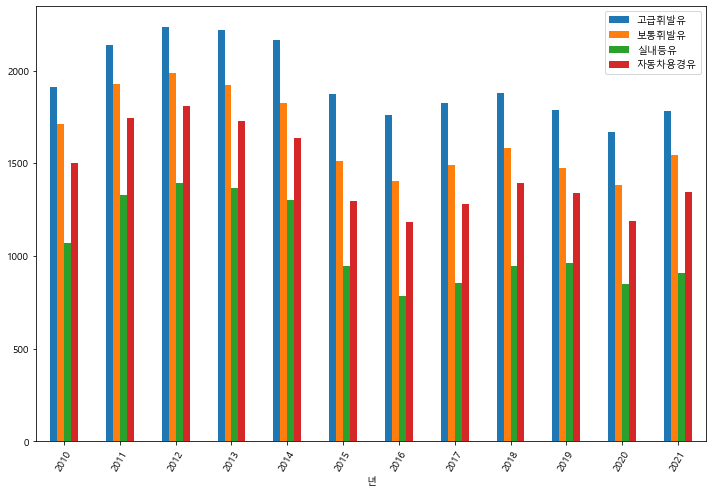

In [29]:
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
st_temp.pivot_table(index='년').drop(columns=['보휘-30']).plot(kind='bar', rot='60', figsize=(12,8))
plt.savefig('src1')

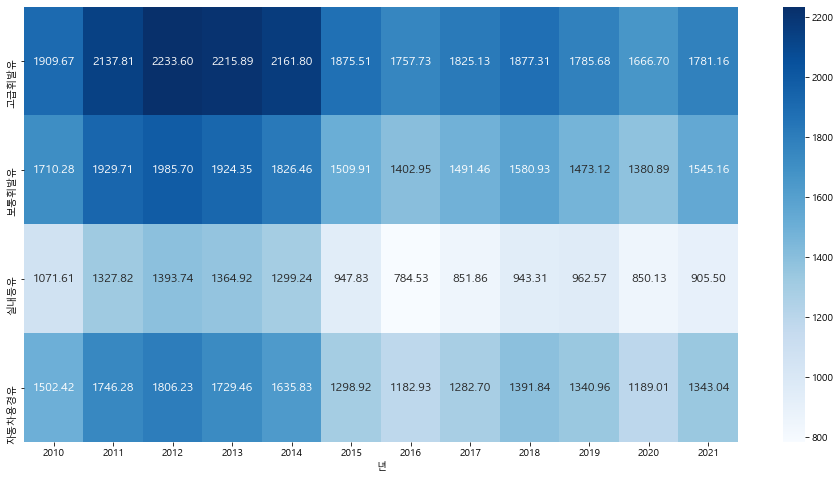

In [30]:
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
plt.figure(figsize=(16,8))
temp = st_temp.pivot_table(index='년').drop(columns=['보휘-30']).T
sns.heatmap(temp, annot=True, fmt='.2f', cmap='Blues', annot_kws={'size':12})
plt.savefig('src2')

In [31]:
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
st_temp

,날짜,고급휘발유,보통휘발유,자동차용경유,실내등유,보휘-30,년,월
0,2010-01-01,1848.43,1641.12,1433.12,1020.11,NaN,2010,01
1,2010-01-02,1853.39,1641.03,1433.11,1021.32,NaN,2010,01
2,2010-01-03,1850.71,1641.28,1432.97,1020.85,NaN,2010,01
3,2010-01-04,1866.87,1644.89,1435.79,1026.02,NaN,2010,01
4,2010-01-05,1866.39,1647.25,1438.20,1028.59,NaN,2010,01
...,...,...,...,...,...,...,...,...
4256,2021-08-27,1878.70,1643.84,1438.32,940.77,0.001102,2021,08
4257,2021-08-28,1878.75,1643.71,1438.04,940.68,0.000700,2021,08
4258,2021-08-29,1878.81,1643.66,1438.21,940.83,0.000371,2021,08
4259,2021-08-30,1878.58,1643.51,1438.06,940.84,-0.000268,2021,08


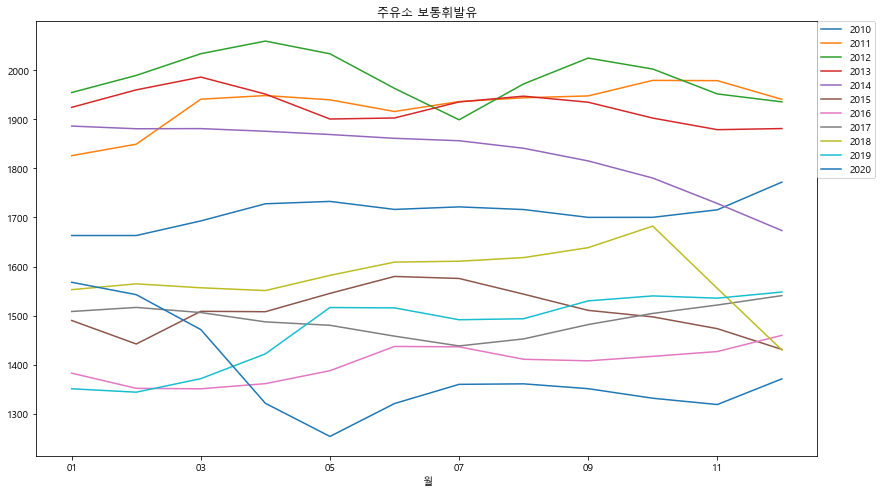

In [32]:
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
gs_temp = gasoline2.copy()
gs_temp['년'] = pd.Series('int')
gs_temp['월'] = pd.Series('int')
for i, y in enumerate(gs_temp['날짜']):
    gs_temp['년'][i] = gs_temp['날짜'][i].split('-')[0]
    gs_temp['월'][i] = gs_temp['날짜'][i].split('-')[1]
temp = gs_temp.groupby(by=['년', '월']).mean().unstack()['주유소 보통휘발유'][:-1].T
temp.plot(figsize=(14, 8), title='주유소 보통휘발유')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('src3')

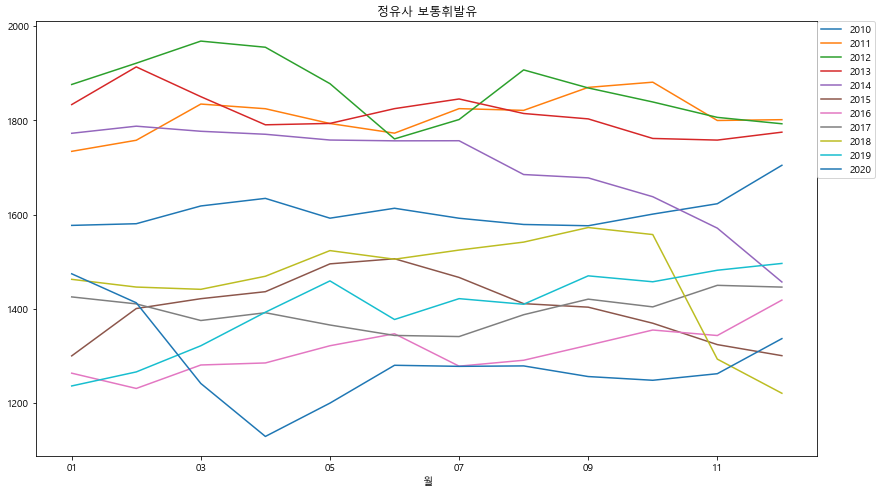

In [33]:
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
gs_temp = gasoline2.copy()
gs_temp['년'] = pd.Series('int')
gs_temp['월'] = pd.Series('int')
for i, y in enumerate(gs_temp['날짜']):
    gs_temp['년'][i] = gs_temp['날짜'][i].split('-')[0]
    gs_temp['월'][i] = gs_temp['날짜'][i].split('-')[1]
temp = gs_temp.groupby(by=['년', '월']).mean().unstack()['정유사 보통휘발유'][:-1].T
temp.plot(figsize=(14, 8), title='정유사 보통휘발유')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.savefig('src4')

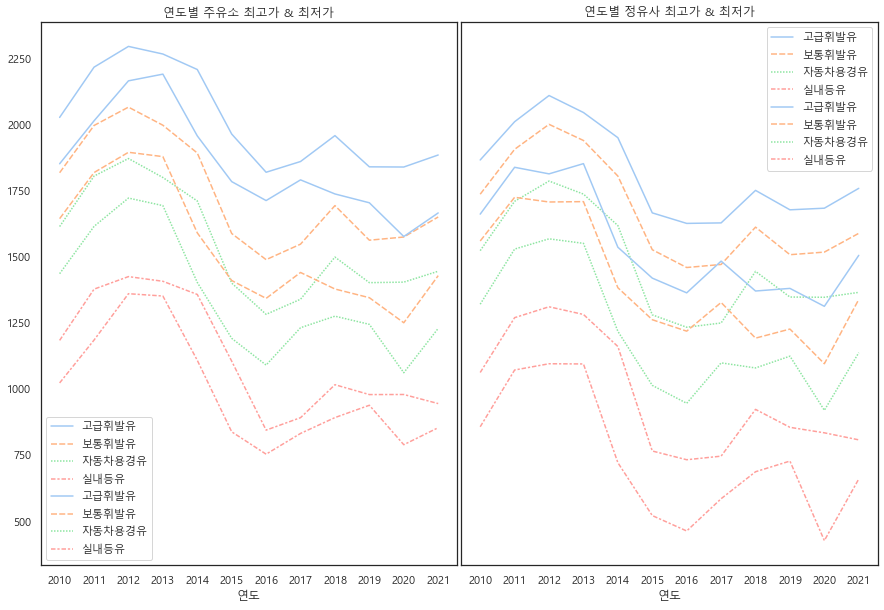

In [34]:
temp1 = station_df.copy()
temp1['연도'] = temp1['날짜'].str[0:4]
temp1.drop(['보휘-30', '날짜'], axis=1, inplace=True)

temp2 = refinery_df.copy()
temp2['연도'] = temp2['날짜'].str[0:4]
temp2.drop(['보휘-4w', '날짜'], axis=1, inplace=True)

d1 = temp1.groupby('연도').max()
d2 = temp1.groupby('연도').min()
d3 = temp2.groupby('연도').max()
d4 = temp2.groupby('연도').min()

sns.set(style='white')
plt.rc("font", family="Malgun Gothic") 
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,10), sharey=True)
plt.subplots_adjust(wspace=0.01)

g1 = sns.lineplot(data=d1, palette='pastel', ax=axes[0])
g2 = sns.lineplot(data=d2, palette='pastel', ax=axes[0])
g3 = sns.lineplot(data=d3, palette='pastel', ax=axes[1])
g4 = sns.lineplot(data=d4, palette='pastel', ax=axes[1])

g1.set(title = '연도별 주유소 최고가 & 최저가')
g3.set(title = '연도별 정유사 최고가 & 최저가')

plt.show()

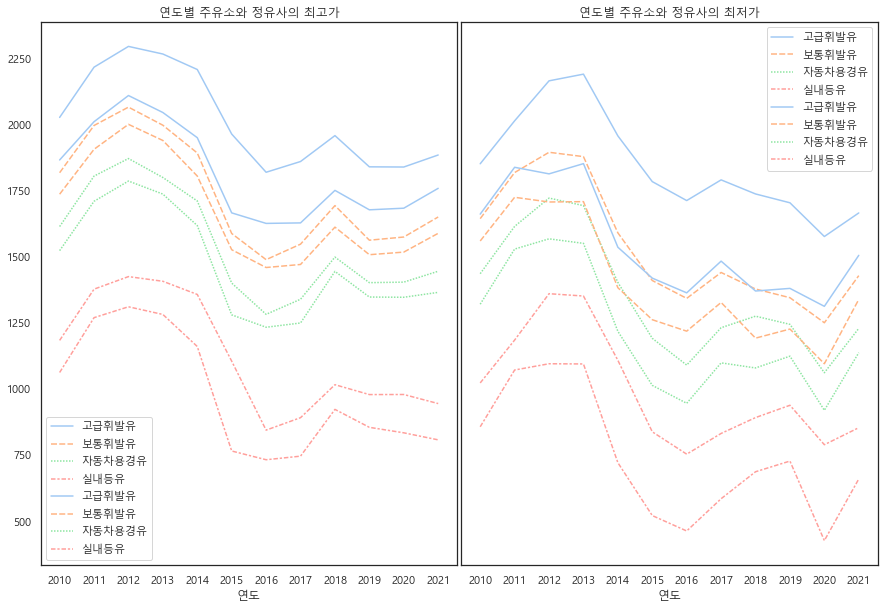

In [35]:
temp1 = station_df.copy()
temp1['연도'] = temp1['날짜'].str[0:4]
temp1.drop(['보휘-30', '날짜'], axis=1, inplace=True)

temp2 = refinery_df.copy()
temp2['연도'] = temp2['날짜'].str[0:4]
temp2.drop(['보휘-4w', '날짜'], axis=1, inplace=True)

d1 = temp1.groupby('연도').max()
d2 = temp1.groupby('연도').min()
d3 = temp2.groupby('연도').max()
d4 = temp2.groupby('연도').min()

sns.set(style='white')
plt.rc("font", family="Malgun Gothic") 
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,10), sharey=True)
plt.subplots_adjust(wspace=0.01)

g1 = sns.lineplot(data=d1, palette='pastel', ax=axes[0])   # d1 : 연도별 최고가 ------- 주유소
g2 = sns.lineplot(data=d3, palette='pastel', ax=axes[0])   # d3 : 연도별 정유사 최고가
g3 = sns.lineplot(data=d2, palette='pastel', ax=axes[1])   # d2 : 연도별 최저가 ------- 주유소
g4 = sns.lineplot(data=d4, palette='pastel', ax=axes[1])   # d4 : 연도별 정유사 최저가

g1.set(title = '연도별 주유소와 정유사의 최고가')
g3.set(title = '연도별 주유소와 정유사의 최저가')

plt.show()

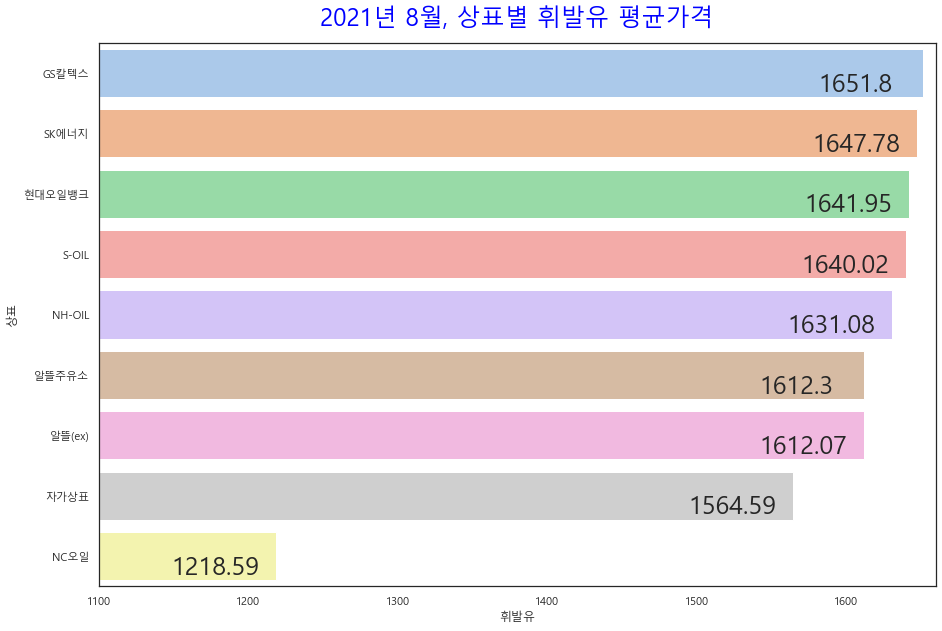

In [36]:
temp = station_now.copy()
temp = temp[['지역', '상표', '휘발유']]
d1 = temp.groupby('상표',as_index=False).mean().round(2)
d1.sort_values('휘발유', ascending=False, inplace=True)

plt.figure(figsize = (15,10))
g1 = sns.barplot(data=d1, y='상표', x='휘발유', palette='pastel', ci=None)
# g1 = sns.barplot(data=d1, x='휘발유', palette='pastel', ci=None)
g1.set_title('2021년 8월, 상표별 휘발유 평균가격', fontdict={'fontsize': 24, 'color':'blue'}, pad=17)

for idx in range(len(d1)) :
    plt.text(d1['휘발유'].iloc[idx]-70, idx+0.3, d1['휘발유'].iloc[idx], size=25)
g1.set_xlim(left=1100, right=1660)
   
plt.savefig('src5')

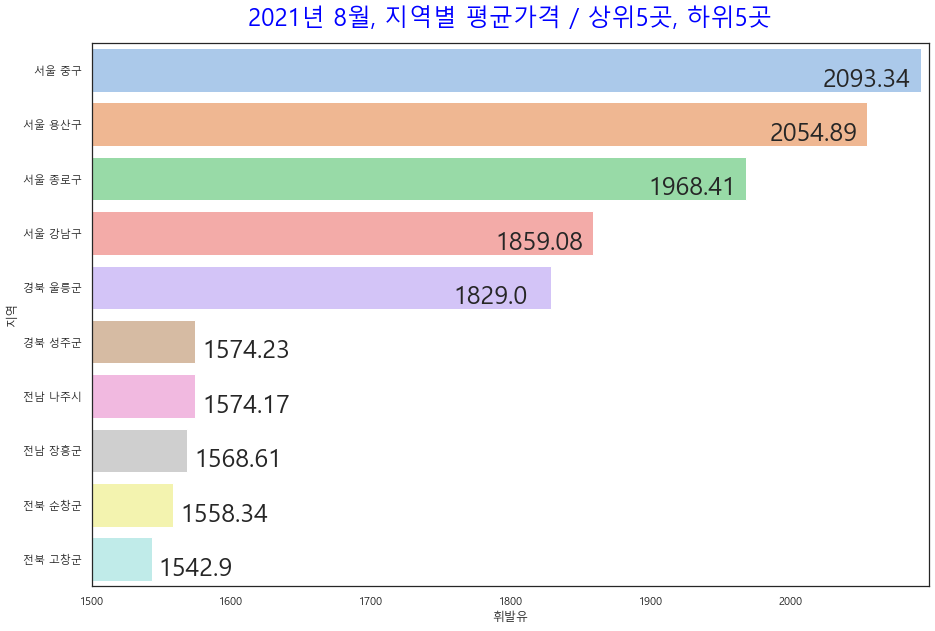

In [37]:
temp = station_now.copy()
temp = temp[['지역', '상표', '휘발유']]
d1 = temp.groupby('지역',as_index=False).mean().round(2)
d1.sort_values('휘발유', ascending=False, inplace=True)
temp1 = d1.head(5)
temp2 = d1.tail(5)
d1 = temp1.append(temp2)
d1.sort_values('휘발유', ascending=False, inplace=True)

plt.figure(figsize = (15,10))
g1 = sns.barplot(data=d1, y='지역', x='휘발유', palette='pastel', ci=None)
# g1 = sns.barplot(data=d1, x='휘발유', palette='pastel', ci=None)
g1.set_title('2021년 8월, 지역별 평균가격 / 상위5곳, 하위5곳', fontdict={'fontsize': 24, 'color':'blue'}, pad=17)

for idx in range(len(d1)) :
    if d1['휘발유'].iloc[idx] > 1600 : 
        plt.text(d1['휘발유'].iloc[idx]-70, idx+0.3, d1['휘발유'].iloc[idx], size=25)
    else :
        plt.text(d1['휘발유'].iloc[idx]+5, idx+0.3, d1['휘발유'].iloc[idx], size=25)    
g1.set_xlim(left=1500, right=2099)
   
plt.savefig('src6')

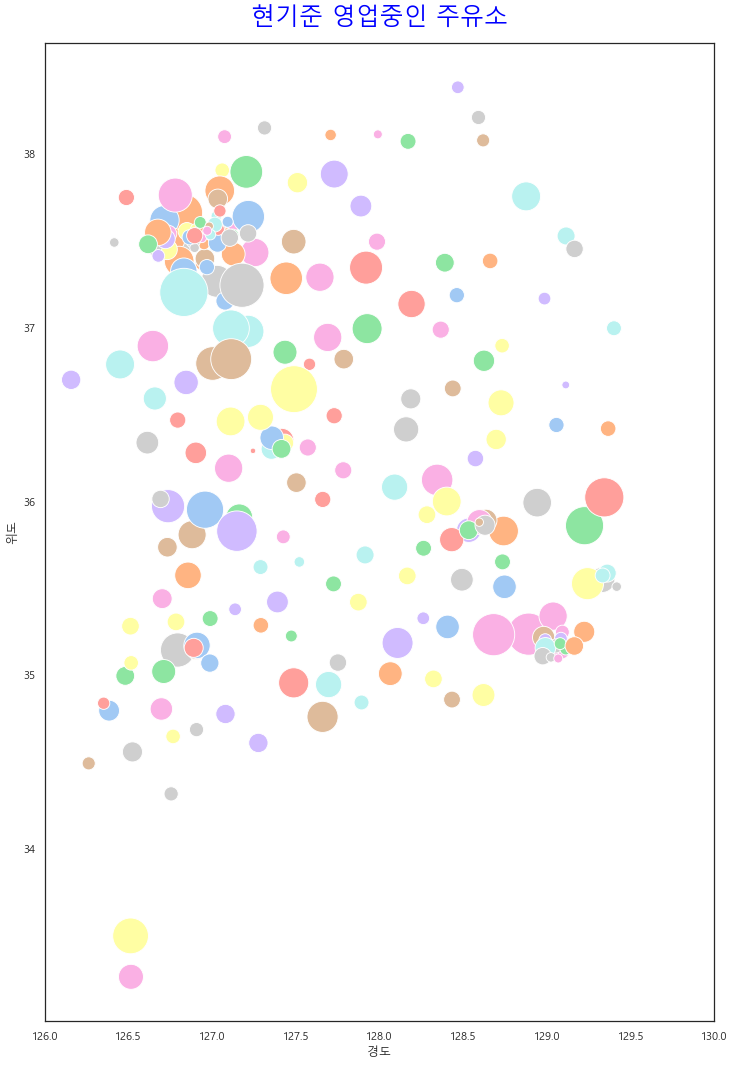

In [38]:
temp = pd.read_csv('data/202108_area.csv')
d1 = temp

sns.set(style='white')
plt.rc("font", family="Malgun Gothic") 
plt.figure(figsize = (12,18))

maxsize_p = max(d1['주유소 수'] * 10)
maxsize_k = max(d1['주유소 수'] * 2)

g1 = sns.scatterplot(data=d1, x='경도', y='위도', size='주유소 수', hue='주유소 수', sizes=(0, maxsize_p), 
                     palette='pastel')

g1.set_title('현기준 영업중인 주유소', fontdict={'fontsize': 24, 'color':'blue'}, pad=17)
g1.get_legend().remove()
g1.set_xlim(left=126, right=130)

plt.savefig('src7')

### 환율 추가

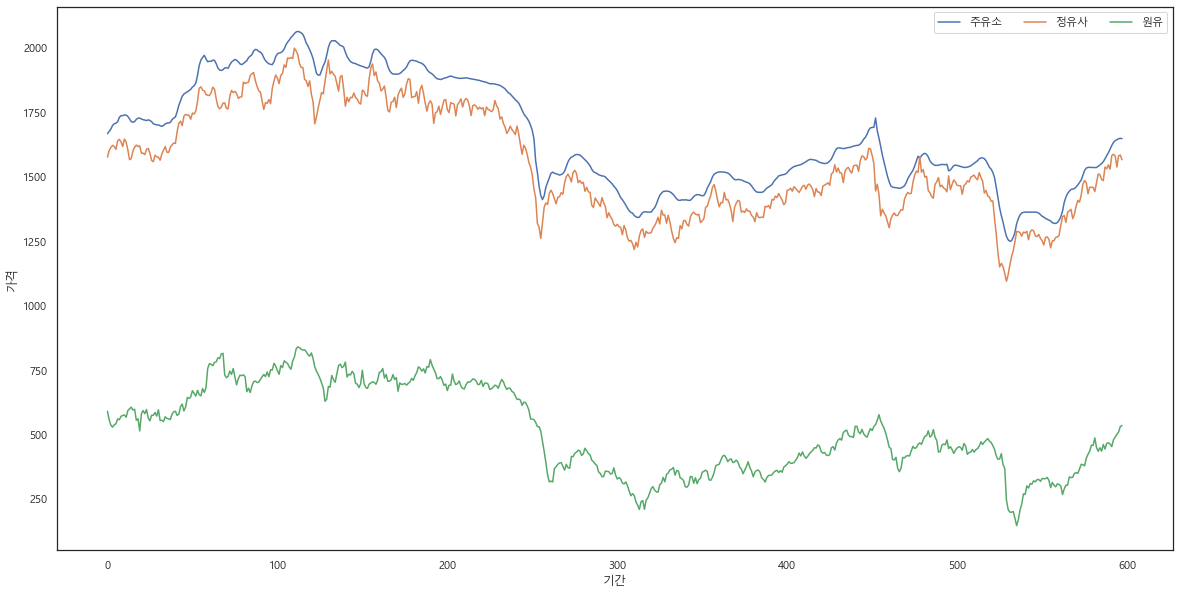

In [39]:
#날짜 통일하여 원유, 정유사, 주유소 그래프 그리기

# 원유가 주유소에 공급되기 까지 과정
# http://www.petroleum.or.kr/ko/sub02/02_8.php 대한석유협회 : 우리나라에서 배가 출발해 다시 돌아와 정유소가는데 약45일 => 42일로 간주
# http://www.petroleum.or.kr/ko/sub02/02_8.php 중앙일보 뉴스 : 정유소에서 정유후 주유소로 가는데 걸리는 시간 7-10 => 7일로 간주

#gasoline2['주유소 보통휘발유'].iloc[7:]  -> 주유소의 처음 7행은 이전 원유이기에 삭제
#gasoline2['정유사 보통휘발유'].iloc[6:-1] -> 정유사의 처음 6행은 이전 원유이여 삭제했고 뒷 일행은 아직 정제중이라 삭제
#gasoline2['환율반영 원유'].iloc[:-7] -> 뒷7행은 배송중인 원유이기에 삭제

#Question ==> 정유사에 주유소 세금을적용

gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

plt.plot(a,label='주유소')
plt.plot(b,label='정유사')
plt.plot(c,label='원유')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=3)

plt.savefig('src8')

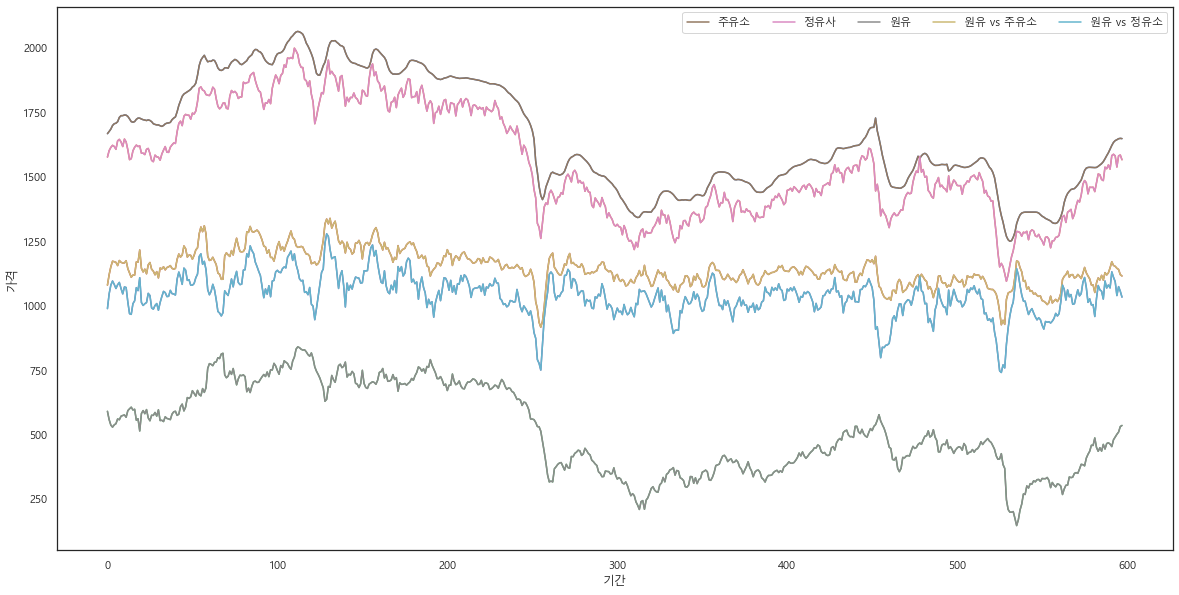

In [40]:
# 기존 그래프에 원유와 주유소차이, 원유와 정유소차이 그래프 추가
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e = d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f = d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.plot(e)
plt.plot(f)

plt.plot(a,label='주유소')
plt.plot(b,label='정유사')
plt.plot(c,label='원유')
plt.plot(e,label='원유 vs 주유소')
plt.plot(f,label='원유 vs 정유소')

plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=5)

plt.savefig('src9')

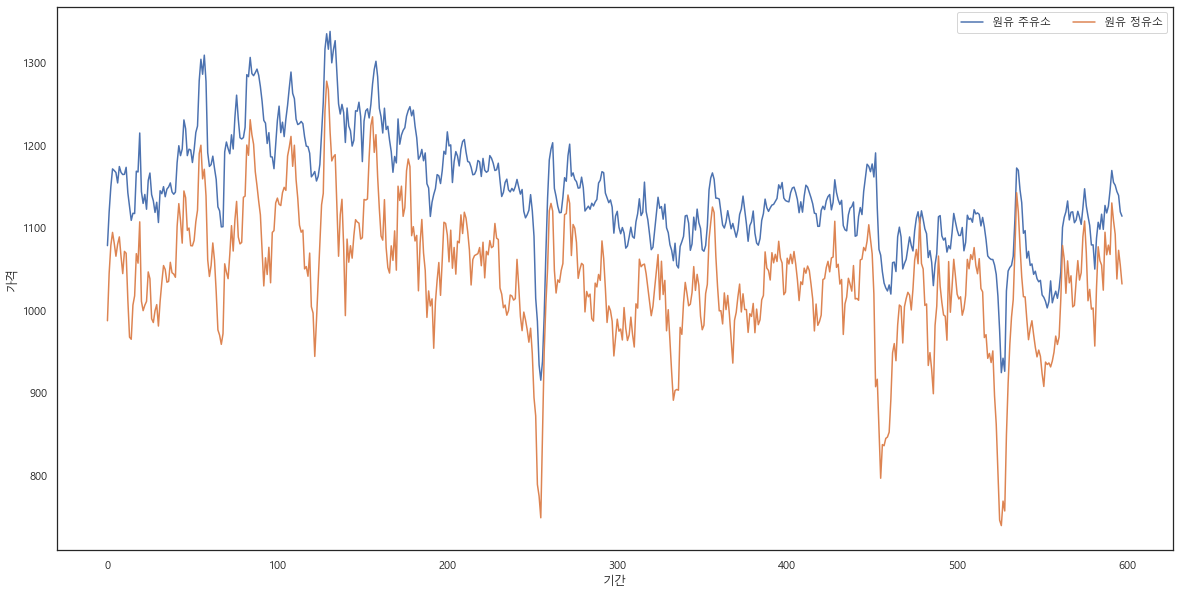

In [41]:
# 원유와 주유소차이, 원유와 정유소차이 그래프 추가
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e= d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f= d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']
plt.plot(e,label='원유 주유소')
plt.plot(f,label='원유 정유소')
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=2)

plt.savefig('src10')

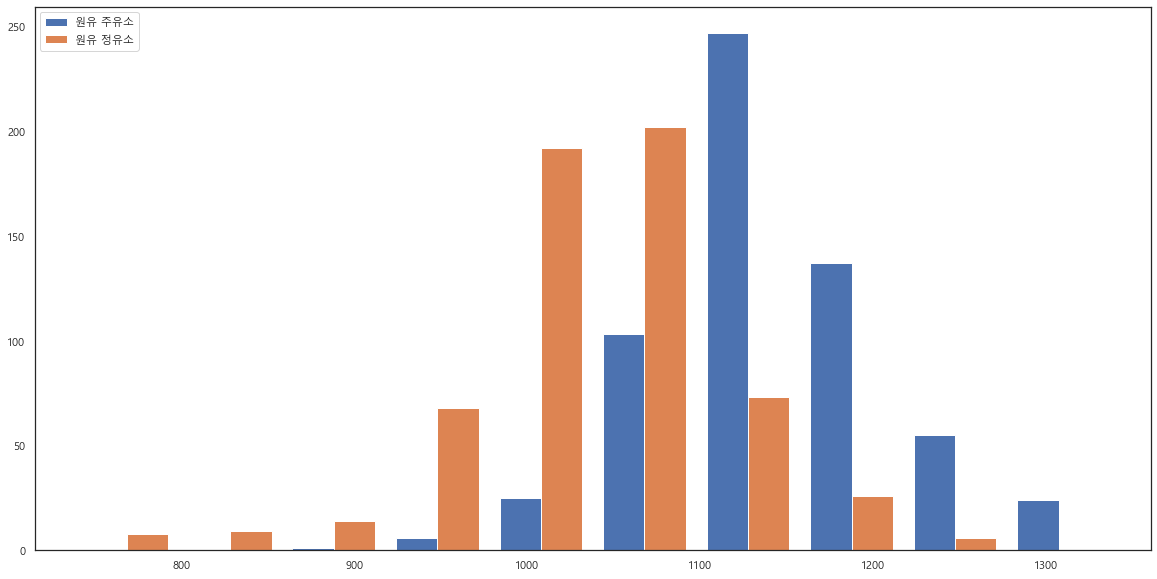

In [42]:
#원유와 주유소 가격차, 원유와 정유소 가격차를 알아보기 위한 희스토그램 
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']
c = c.reset_index()['환율반영 원유']  # 인덱스 통일
d = pd.concat([a,b,c],axis=1)

e= d['원유와 주유소가격 차이'] = d['주유소 보통휘발유 세금반영']-d['환율반영 원유']
f= d['원유와 정유사가격 차이'] = d['정유사 보통휘발유 세금반영']-d['환율반영 원유']


plt.hist([e,f],label=['원유 주유소','원유 정유소'])
plt.legend(loc='upper left')

plt.savefig('src11')

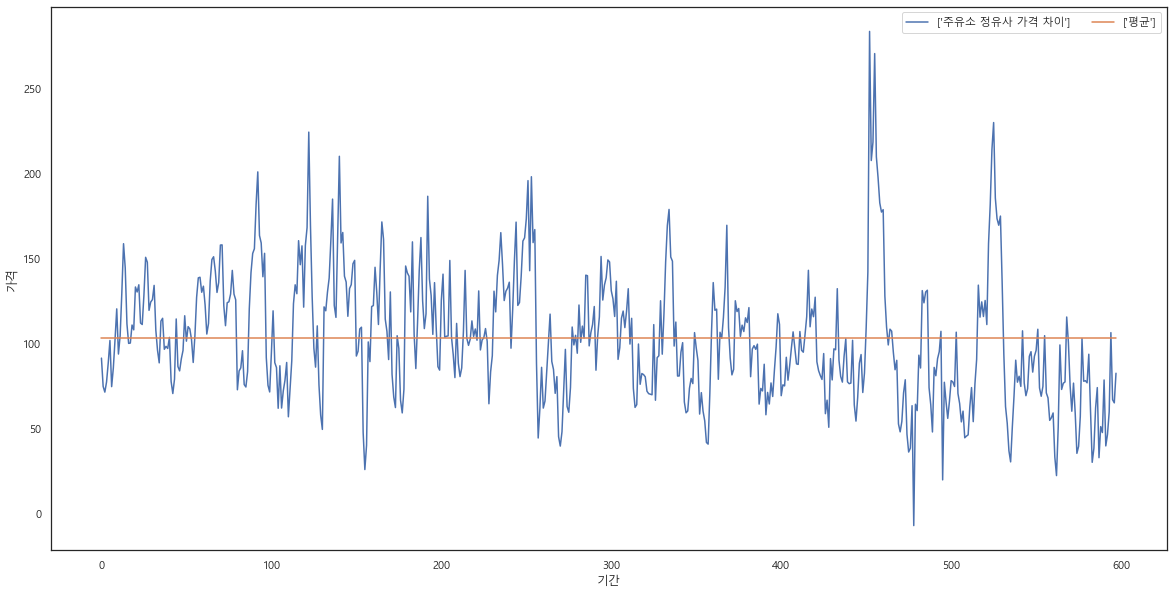

In [43]:
# 주유소 정유소 가격차이와 평균
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']


e = a-b
e = e.to_frame()
e['평균'] = pd.Series()
e['평균'] = e['평균'].apply(lambda x : e.mean())

plt.plot(e[0], label=['주유소 정유사 가격 차이'])
plt.plot(e['평균'], label=['평균'])
plt.xlabel('기간')
plt.ylabel('가격')
plt.legend(ncol=2)

plt.savefig('src12')

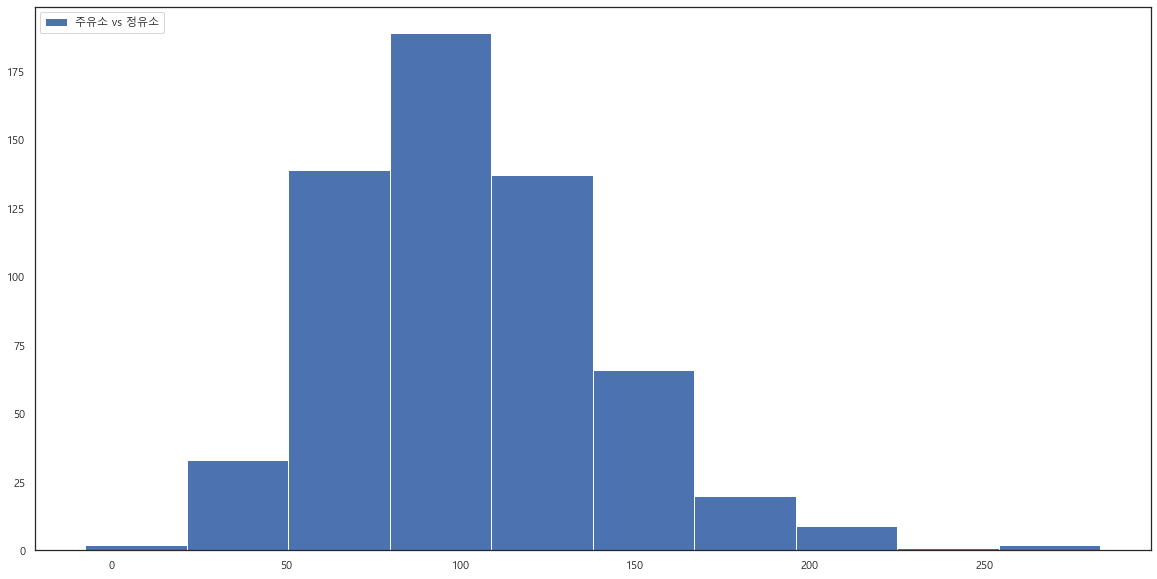

In [44]:
# 주유소와 정유소 가격차를 알아보기위한 희스토그램
gasoline2 = pd.read_csv('data/gasoline2.csv', encoding='CP949')
plt.figure(figsize=(20,10))

a =gasoline2['주유소 보통휘발유 세금반영'].iloc[7:]
b = gasoline2['정유사 보통휘발유 세금반영'].iloc[6:-1]
c = gasoline2['환율반영 원유'].iloc[:-7]

a = a.reset_index()['주유소 보통휘발유 세금반영']
b = b.reset_index()['정유사 보통휘발유 세금반영']

e= a-b

plt.hist(e,label='주유소 vs 정유소')
plt.legend(loc='upper left')

plt.savefig('src13')

# 웹크롤링

## 날짜선정

In [2]:
def detail(a=201002, b=202108, figsize=(20,10), name=None):
    '''
    parameters
    ----------
    ex) 2012년 3월 12일 ~ 2013년 4월 15일
    a = 120312
    b = 130415
    figsize = 그래프 사이즈
    name = "저장할 파일 이름"
    '''
    price1 = station_correct_date[['날짜','주유소 보통휘발유']]
    price2 = station_correct_date[['날짜','환율반영 원유']]
    
    M = str(a)[:4] + '-' + str(a)[4:]
    N = str(b)[:4] + '-' + str(b)[4:]
    
    A = pd.Series(price1['날짜']).str.contains(M).idxmax()
    B = pd.Series(price1['날짜']).str.contains(N).idxmax()
    
    price1['날짜'] = pd.to_datetime(price1['날짜'])
    price1.index = price1['날짜']
    price1 = price1['주유소 보통휘발유']
    price2['날짜'] = pd.to_datetime(price2['날짜'])
    price2.index = price2['날짜']
    price2 = price2['환율반영 원유']
    
    plt.rc('font', size=30)        # 기본 폰트 크기
    plt.rc('axes', labelsize=30)   # x,y축 label 폰트 크기
    plt.rc('xtick', labelsize=30)  # x축 눈금 폰트 크기 
    plt.rc('ytick', labelsize=30)  # y축 눈금 폰트 크기
    plt.rc('legend', fontsize=30)  # 범례 폰트 크기

    plt.figure(figsize=figsize)
    plt.plot(price1[A:B], 'r', label='국내휘발유값')
    plt.legend()
    plt.text(x=price1[A:B].idxmax(), y=price1[A:B].max(), s='* 휘발유 :'+str(round(price1[A:B].max(),2))+' ('+str(price1[A:B].idxmax()).split(' ')[0]+')', size=34, color='r')
    plt.text(x=price1[A:B].idxmin(), y=price1[A:B].min(), s='* 휘발유 :'+str(round(price1[A:B].min(),2))+' ('+str(price1[A:B].idxmin()).split(' ')[0]+')', size=34, color='r')
    
#     plt.plot(price2[A:B], 'g', label='국제유가')
#     plt.legend()
#     plt.text(x=price2[A:B].idxmax(), y=price2[A:B].max(), s='* 원유 :'+str(round(price2[A:B].max(),2))+' ('+str(price2[A:B].idxmax()).split(' ')[0]+')', size=40, color='g')
#     plt.text(x=price2[A:B].idxmin(), y=price2[A:B].min(), s='* 원유 :'+str(round(price1[A:B].min(),2))+' ('+str(price1[A:B].idxmin()).split(' ')[0]+')', size=30, color='g')
#     plt.xlabel('기간')
#     plt.ylabel('값')
    
    if name:
        plt.savefig(name+".png")
    
    print('최대')
    print('원 유 : '+str(round(price2[A:B].max(),2))+' ('+str(price2[A:B].idxmax()).split(' ')[0]+')')
    print('휘발유 : '+str(round(price1[A:B].max(),2))+' ('+str(price1[A:B].idxmax()).split(' ')[0]+')')   
    print('최소')
    print('원 유 : '+str(round(price2[A:B].min(),2))+' ('+str(price2[A:B].idxmin()).split(' ')[0]+')')
    print('휘발유 : '+str(round(price1[A:B].min(),2))+' ('+str(price1[A:B].idxmin()).split(' ')[0]+')')

최대
원 유 : 838.18 (2012-04-18)
휘발유 : 2062.44 (2012-04-18)
최소
원 유 : 144.52 (2020-06-10)
휘발유 : 1247.95 (2020-05-13)


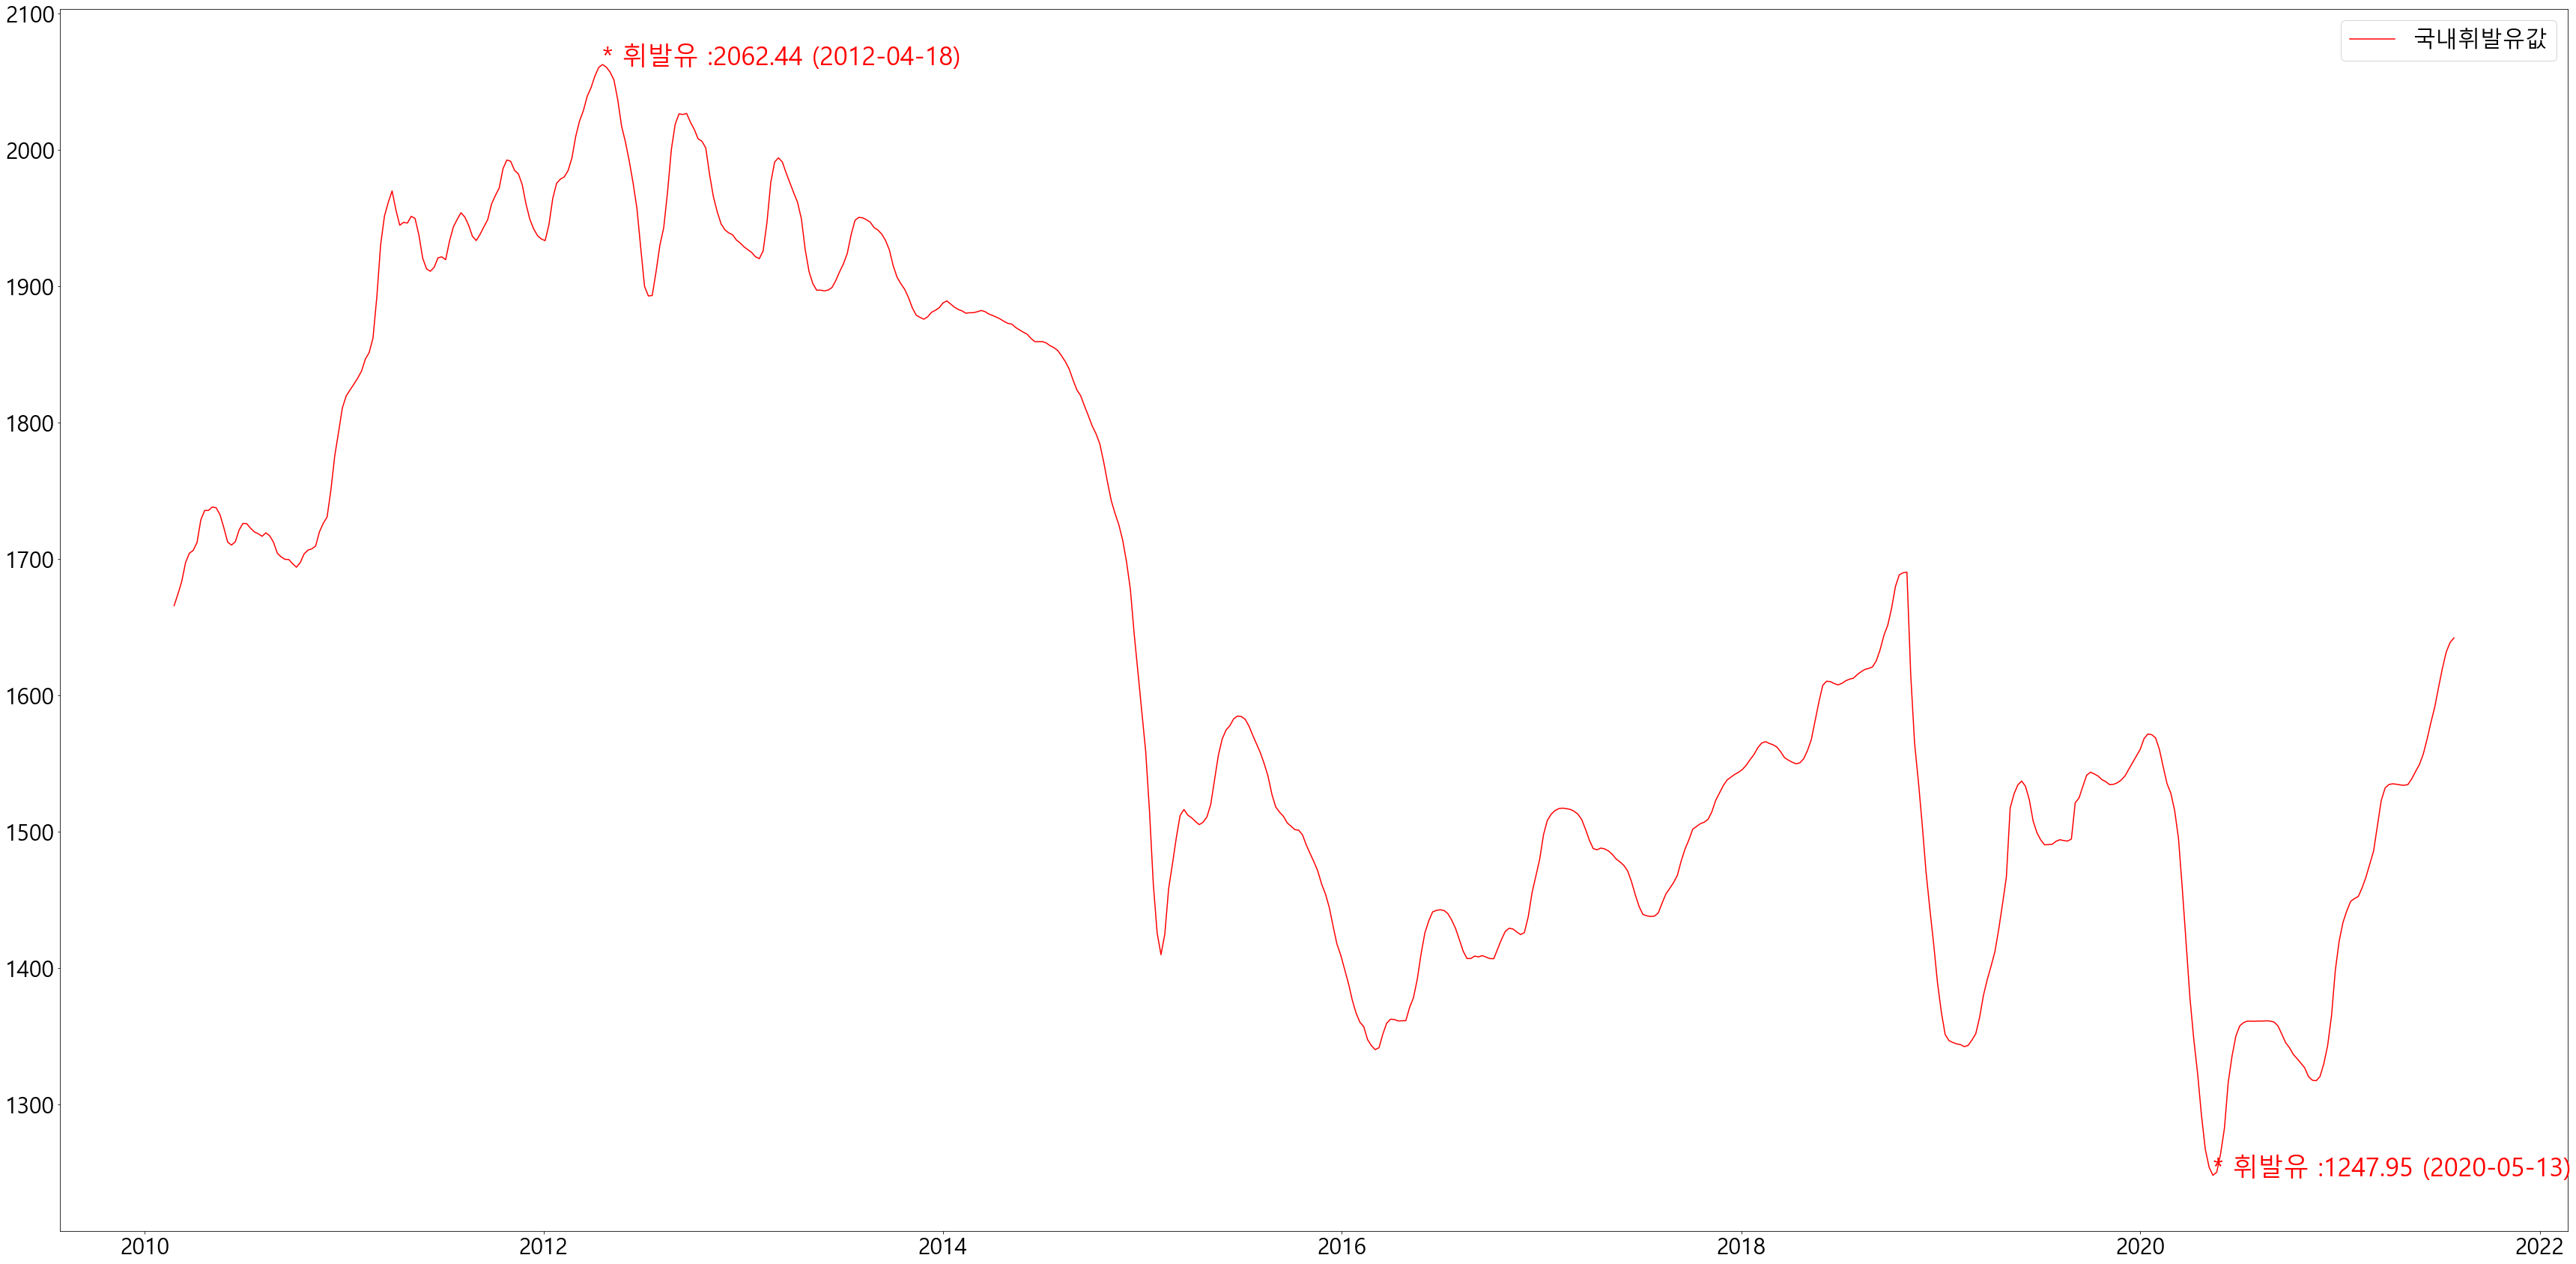

In [6]:
station_correct_date = gasoline2.iloc[7:,0:2].reset_index().iloc[:,1:]
station_correct_date = pd.concat([station_correct_date,gasoline2['환율반영 원유'].iloc[:-7].to_frame()],axis=1)
#전체기간
detail(name="2010-2021.최대최소 국제원유가격", figsize=(60,30))

## 2020-05-13->2020-05-27 웹크롤링과 워드클라우드(저점)

In [66]:
import requests
from bs4 import BeautifulSoup
import re

sentences=[] 
a=1
for b in range(1,298):
    try:
        start_date1='2020.05.13'    # 검색 희망 시작일
        start_date = '20120513'     # 검색 희망 시작일
        end_data1 = '2012.05.27'    # 검색 희망 종료일
        end_date = '20120527'       # 검색 희망 종료일
        
        url = f'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%EA%B5%AD%EC%A0%9C%EC%9C%A0%EA%B0%80&sort=0&photo=0&field=0&pd=3&ds={start_date1}&de={end_data1}&cluster_rank=40&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date},a:all&start={a}'
        response= requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")
        links=soup.select(".news_tit") # list 형으로 경과 나옴
        a+=10
        for link in links:
            title = link.text # 태그 안에 텍스트 요소를 가지고옴
#             url = link.attrs['href'] # href의 속성값 을가지고옴 (url)
            sentences.append(title)   
    except:
        print("기사가 더이상 없습니다.")

new_list = []
for v in sentences:
    if v not in new_list:
        new_list.append(v)

with open("data/2020.05.13 - 2020.05.27.txt", "w", encoding='utf-8') as f:
    for line in new_list:
        f.write(line)    

기사가 더이상 없습니다.
기사가 더이상 없습니다.


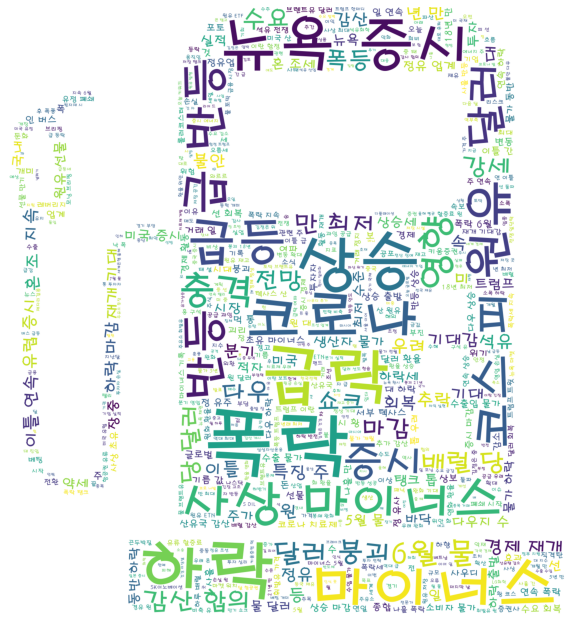

In [67]:
with open('data/2020.05.13 - 2020.05.27.txt','r', encoding='utf-8') as txtfile:
    data = txtfile.readlines()
    
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Komoran
komoran = Komoran(max_heap_size=2024)
from konlpy.corpus import kolaw
from wordcloud import STOPWORDS
불용어 = STOPWORDS | set(['국제', '유가', '2012년 4월', '4월', '3월', '2012년'])

word_list = komoran.nouns('%r' % data)
text = ' '.join(word_list)

from PIL import Image
import numpy as np
img = Image.open('img/1111.png').convert('RGBA') # RGB와 투명도
mask = np.array(img)
wordcloud = WordCloud(background_color='white',
                      max_words=600,
                      font_path='c:/Windows/Fonts/H2PORM.TTF',
                      relative_scaling=0.3,
                      mask=mask,
                      stopwords=불용어)
wordcloud.generate(text)
plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('data/worldcloud_2020.05.13 - 2020.05.27.png')
plt.show()

## 2012-04-18->2012-05-02 웹크롤링과 워드클라우드(고점)

In [68]:
import requests
from bs4 import BeautifulSoup
import re

sentences=[] 
a=1
for b in range(1,298):
    try:
        start_date1='2012.04.18'    # 검색 희망 시작일
        start_date = '20120418'     # 검색 희망 시작일
        end_data1 = '2012.05.02'    # 검색 희망 종료일
        end_date = '20120502'       # 검색 희망 종료일
        
        url = f'https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%EA%B5%AD%EC%A0%9C%EC%9C%A0%EA%B0%80&sort=0&photo=0&field=0&pd=3&ds={start_date1}&de={end_data1}&cluster_rank=40&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:from{start_date}to{end_date},a:all&start={a}'
        response= requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")
        links=soup.select(".news_tit") # list 형으로 경과 나옴
        a+=10
        for link in links:
            title = link.text # 태그 안에 텍스트 요소를 가지고옴
#             url = link.attrs['href'] # href의 속성값 을가지고옴 (url)
            sentences.append(title)   
    except:
        print("기사가 더이상 없습니다.")

new_list = []
for v in sentences:
    if v not in new_list:
        new_list.append(v)

with open("data/2012.04.18 - 2012.05.02.txt", "w", encoding='utf-8') as f:
    for line in new_list:
        f.write(line)  

기사가 더이상 없습니다.


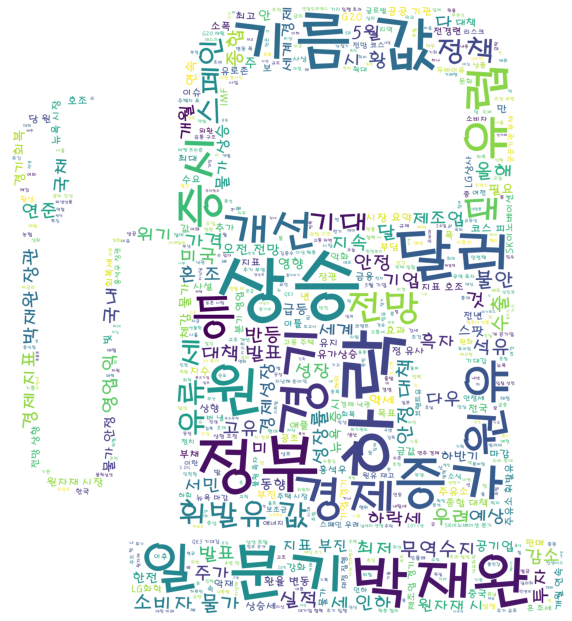

In [69]:
with open('data/2012.04.18 - 2012.05.02.txt','r', encoding='utf-8') as txtfile:
    data = txtfile.readlines()
    
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from konlpy.tag import Komoran
komoran = Komoran(max_heap_size=2024)
from konlpy.corpus import kolaw
from wordcloud import STOPWORDS
불용어 = STOPWORDS | set(['국제', '유가', '2012년 4월', '4월', '3월', '2012년'])

word_list = komoran.nouns('%r' % data)
text = ' '.join(word_list)

from PIL import Image
import numpy as np
img = Image.open('img/1111.png').convert('RGBA') # RGB와 투명도
mask = np.array(img)
wordcloud = WordCloud(background_color='white',
                      max_words=600,
                      font_path='c:/Windows/Fonts/H2PORM.TTF',
                      relative_scaling=0.3,
                      mask=mask,
                      stopwords=불용어)
wordcloud.generate(text)
plt.figure(figsize=(10,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('data/worldcloud_2012.04.18 - 2012.05.02.png')
plt.show()

# 임시 카테고리 ( 필요한 그래프 )

## 히트맵 연도별 유종별

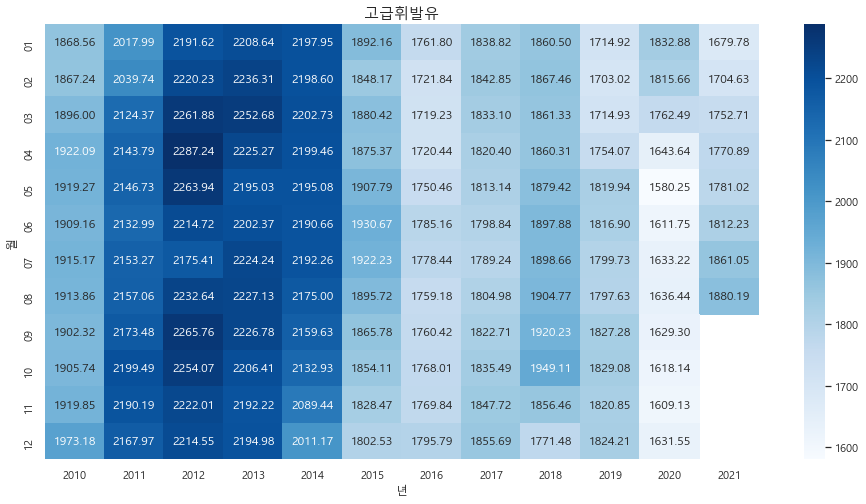

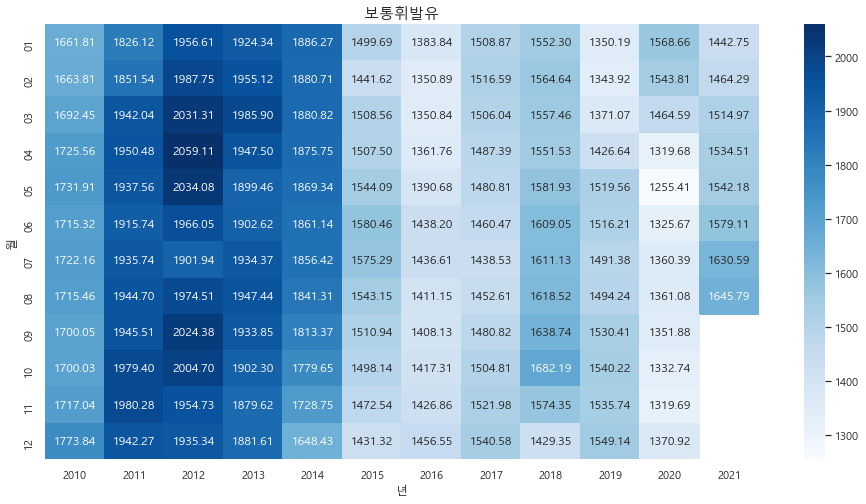

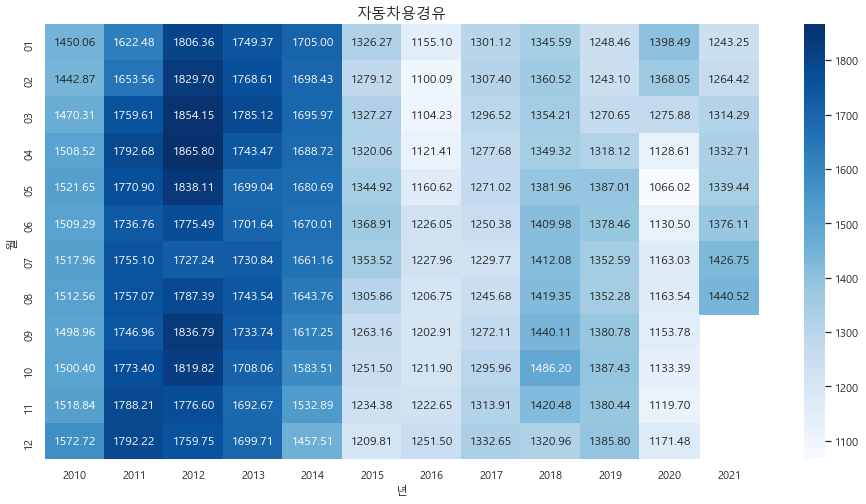

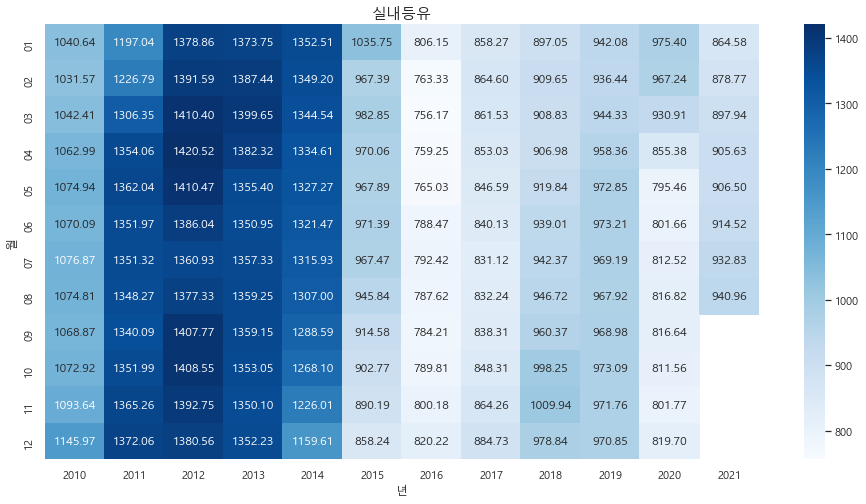

In [47]:
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
for kind in st_temp.columns[1:5]:
    plt.figure(figsize=(16,8))
    temp = st_temp.pivot_table(index='월', columns='년', values=kind)
    sns.heatmap(temp, annot=True, fmt='.2f', cmap='Blues', annot_kws={'size':12})
    plt.title(kind, fontdict={'size':15})
#     plt.savefig(kind+'png') 하나씩 저장

## 꺾은선 : 원유 매년 월별 그래프

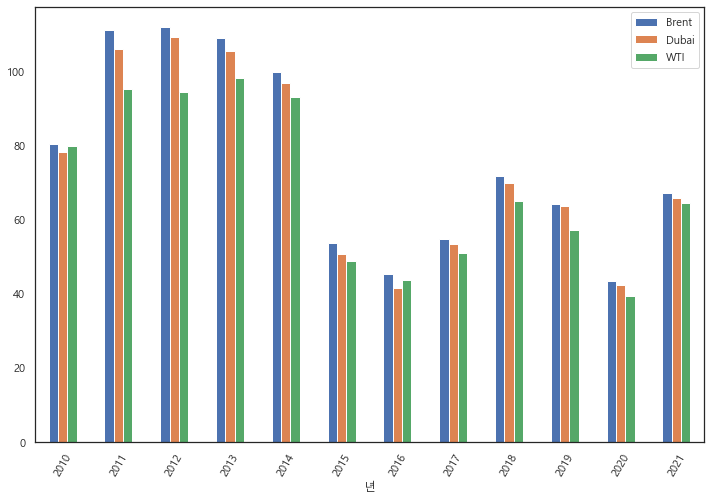

In [48]:
# 연도별 (막대)
crude_df = pd.read_csv('data/crude_df.csv')
c_temp = crude_df.copy()
c_temp['년'] = pd.Series('int')
c_temp['월'] = pd.Series('int')
for i, y in enumerate(c_temp['날짜']):
    c_temp['년'][i] = c_temp['날짜'][i].split('-')[0]
    c_temp['월'][i] = c_temp['날짜'][i].split('-')[1]
c_temp.pivot_table(index='년').drop(columns=['평균', '평균-30']).plot(kind='bar', rot='60', figsize=(12,8))
plt.savefig('src14')

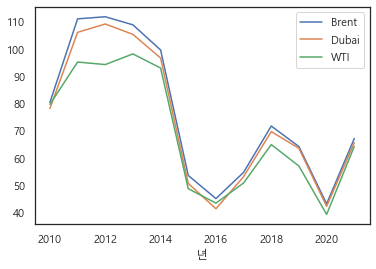

In [49]:
# 연도별 (라인)
crude_df = pd.read_csv('data/crude_df.csv')
c_temp = crude_df.copy()
c_temp['년'] = pd.Series('int')
c_temp['월'] = pd.Series('int')
for i, y in enumerate(c_temp['날짜']):
    c_temp['년'][i] = c_temp['날짜'][i].split('-')[0]
    c_temp['월'][i] = c_temp['날짜'][i].split('-')[1]
c_temp.pivot_table(index='년').drop(columns=['평균', '평균-30']).plot(kind='line')
plt.savefig('temp1')
plt.savefig('src15')

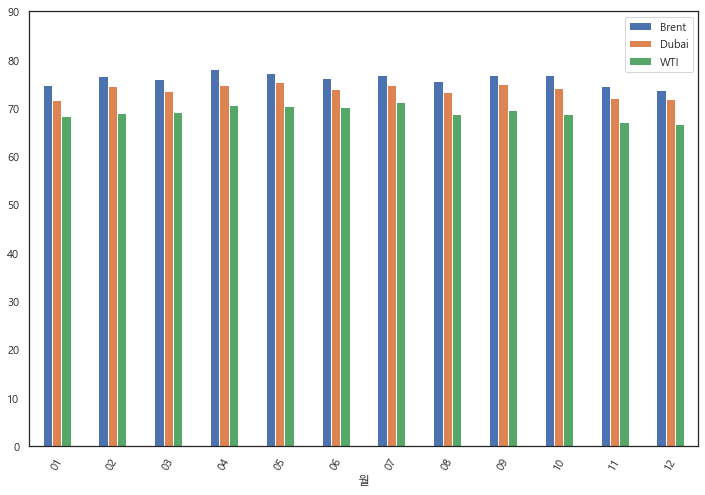

In [50]:
# 월별 (막대)
crude_df = pd.read_csv('data/crude_df.csv')
c_temp = crude_df.copy()
c_temp['년'] = pd.Series('int')
c_temp['월'] = pd.Series('int')
for i, y in enumerate(c_temp['날짜']):
    c_temp['년'][i] = c_temp['날짜'][i].split('-')[0]
    c_temp['월'][i] = c_temp['날짜'][i].split('-')[1]
c_temp.pivot_table(index='월').drop(columns=['평균', '평균-30']).plot(kind='bar', rot='60', figsize=(12,8), ylim=[0, 90])
plt.savefig('src16')

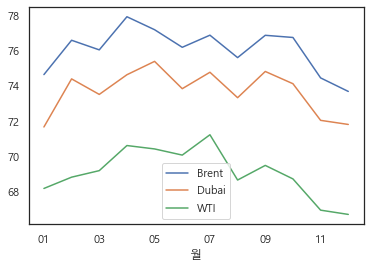

In [51]:
# 월별 (라인)
crude_df = pd.read_csv('data/crude_df.csv')
c_temp = crude_df.copy()
c_temp['년'] = pd.Series('int')
c_temp['월'] = pd.Series('int')
for i, y in enumerate(c_temp['날짜']):
    c_temp['년'][i] = c_temp['날짜'][i].split('-')[0]
    c_temp['월'][i] = c_temp['날짜'][i].split('-')[1]
c_temp.pivot_table(index='월').drop(columns=['평균', '평균-30']).plot(kind='line')
plt.savefig('src17')

## 꺾은선 : 주유소 // 휘발유 월별 그래프

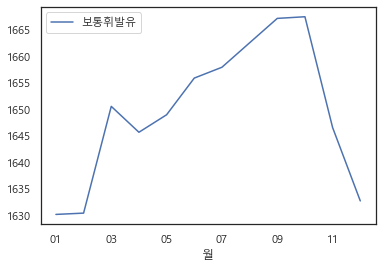

In [52]:
# 보통
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
st_temp.pivot_table(index='월', values='보통휘발유').plot(kind='line')
plt.savefig('src18')

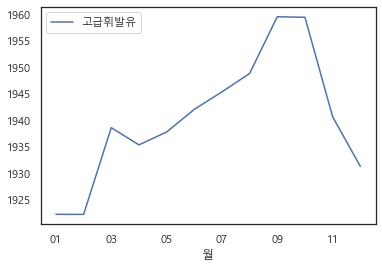

In [53]:
# 고급
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
st_temp.pivot_table(index='월', values='고급휘발유').plot(kind='line')
plt.savefig('src19')

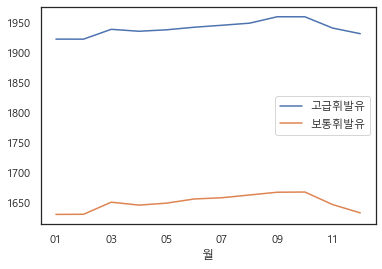

In [54]:
# 보통 & 고급
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
st_temp.pivot_table(index='월', values=['보통휘발유','고급휘발유']).plot(kind='line')
plt.savefig('src20')

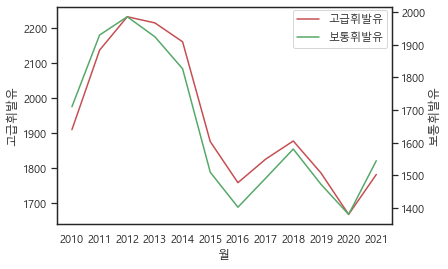

In [55]:
# 보통 & 고급 (트윈)
station_df = pd.read_csv('data/station_df.csv')
st_temp = station_df.copy()
st_temp['년'] = pd.Series('int')
st_temp['월'] = pd.Series('int')
for i, y in enumerate(st_temp['날짜']):
    st_temp['년'][i] = st_temp['날짜'][i].split('-')[0]
    st_temp['월'][i] = st_temp['날짜'][i].split('-')[1]
price1 = st_temp.pivot_table(index='년', values='고급휘발유')
price2 = st_temp.pivot_table(index='년', values='보통휘발유')

fig, ax1 = plt.subplots()
ax1.plot(price1, 'r', label='고급휘발유')
ax1.set_xlabel('월')
ax1.set_ylabel('고급휘발유')

ax2 = ax1.twinx()
ax2.plot(price2, 'g', label='보통휘발유')
ax2.set_ylabel('보통휘발유')

fig.legend(bbox_to_anchor=(0.89, .87), loc=1, borderaxespad=0.)

plt.savefig('temp2')
plt.savefig('src21')